Evaluating:   4%|▍         | 50/1221 [00:11<04:19,  4.51it/s]


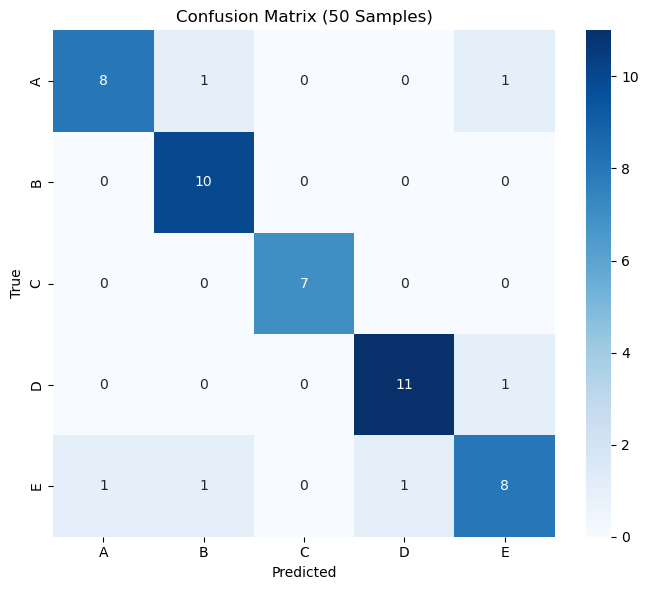


🔍 RAG + Live Search Accuracy (50 samples): 88.00%

Confusion Matrix (rows=True, cols=Pred):
 [[ 8  1  0  0  1]
 [ 0 10  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  0 11  1]
 [ 1  1  0  1  8]]


In [ ]:
import os
import requests
import openai
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set your API keys here
SERPAPI_API_KEY = ""
openai.api_key = ""  

# Load model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
test_dataset_raw = load_dataset("tau/commonsense_qa", split="validation")

# Helper: Format the multiple-choice question
def format_example(example):
    prompt = f"Question: {example['question']}\n"
    for idx, choice in enumerate(example["choices"]["text"]):
        prompt += f"{chr(ord('A') + idx)}. {choice}\n"
    prompt += "Answer:"
    return prompt

# Helper: Run web search using SerpAPI
def web_search_serpapi(query, serpapi_key):
    params = {
        "q": query,
        "api_key": serpapi_key,
        "engine": "google",
        "num": 5,
    }
    response = requests.get("https://serpapi.com/search", params=params)
    data = response.json()
    snippets = []
    if "organic_results" in data:
        for result in data["organic_results"]:
            if "snippet" in result:
                snippets.append(result["snippet"])
    return " ".join(snippets[:3])  # Take top 3 snippets

# Helper: Generate answer with context
def answer_with_context(context, prompt):
    full_prompt = f"{context}\n\n{prompt}"
    inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=5)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return pred

# RAG pipeline with live web search and confusion matrix
def run_rag_live(test_dataset, max_samples=50):
    label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    y_true = []
    y_pred = []

    for i, example in enumerate(tqdm(test_dataset, desc="Evaluating")):
        if i >= max_samples:
            break
        question = example["question"]
        context = web_search_serpapi(question, SERPAPI_API_KEY)
        prompt = format_example(example)
        pred = answer_with_context(context, prompt)
        
        # Map true and predicted labels
        true_label = label_map[example["answerKey"]]
        try:
            pred_label = label_map[pred.strip().upper()[0]]  # Take first character
        except (KeyError, IndexError):
            pred_label = -1  # For invalid predictions
            
        y_true.append(true_label)
        y_pred.append(pred_label)

    # Confusion matrix (ignore invalid predictions in plotting)
    valid_idx = [i for i, p in enumerate(y_pred) if p in range(5)]
    y_true_valid = [y_true[i] for i in valid_idx]
    y_pred_valid = [y_pred[i] for i in valid_idx]

    labels = ['A', 'B', 'C', 'D', 'E']
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=list(range(5)))

    # Plot confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix (50 Samples)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Calculate accuracy (on all samples)
    total = len(y_true)
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    accuracy = correct / total

    return accuracy, cm

# Run evaluation
accuracy, cm = run_rag_live(test_dataset_raw)
print(f"\n🔍 RAG + Live Search Accuracy (50 samples): {accuracy:.2%}")
print("\nConfusion Matrix (rows=True, cols=Pred):\n", cm)


Evaluating: 100%|██████████| 1221/1221 [04:18<00:00,  4.73it/s]


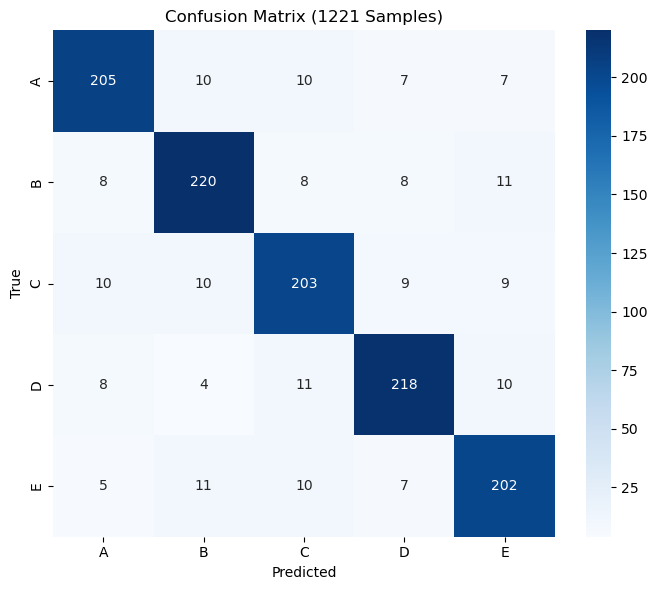


🔍 RAG + Live Search Accuracy (all 1221 test samples): 85.83%

Confusion Matrix (rows=True, cols=Pred):
 [[205  10  10   7   7]
 [  8 220   8   8  11]
 [ 10  10 203   9   9]
 [  8   4  11 218  10]
 [  5  11  10   7 202]]


In [ ]:
import os
import requests
import openai
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set your API keys here
SERPAPI_API_KEY = ""
openai.api_key = ""

# Load model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset (test set = validation split)
test_dataset = load_dataset("tau/commonsense_qa", split="validation")

def format_example(example):
    prompt = f"Question: {example['question']}\n"
    for idx, choice in enumerate(example["choices"]["text"]):
        prompt += f"{chr(ord('A') + idx)}. {choice}\n"
    prompt += "Answer:"
    return prompt

def web_search_serpapi(query, serpapi_key):
    params = {
        "q": query,
        "api_key": serpapi_key,
        "engine": "google",
        "num": 5,
    }
    response = requests.get("https://serpapi.com/search", params=params)
    data = response.json()
    snippets = []
    if "organic_results" in data:
        for result in data["organic_results"]:
            if "snippet" in result:
                snippets.append(result["snippet"])
    return " ".join(snippets[:3])  # Take top 3 snippets

def answer_with_context(context, prompt):
    full_prompt = f"{context}\n\n{prompt}"
    inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=5)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return pred

def run_rag_live(test_dataset, max_samples=None):
    label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    y_true = []
    y_pred = []
    total_samples = len(test_dataset) if max_samples is None else min(max_samples, len(test_dataset))

    for i, example in enumerate(tqdm(test_dataset, desc="Evaluating")):
        if max_samples is not None and i >= max_samples:
            break
        question = example["question"]
        context = web_search_serpapi(question, SERPAPI_API_KEY)
        prompt = format_example(example)
        pred = answer_with_context(context, prompt)
        
        true_label = label_map[example["answerKey"]]
        try:
            pred_label = label_map[pred.strip().upper()[0]]
        except (KeyError, IndexError):
            pred_label = -1  # For invalid predictions
            
        y_true.append(true_label)
        y_pred.append(pred_label)

    # Confusion matrix (ignore invalid predictions in plotting)
    valid_idx = [i for i, p in enumerate(y_pred) if p in range(5)]
    y_true_valid = [y_true[i] for i in valid_idx]
    y_pred_valid = [y_pred[i] for i in valid_idx]

    labels = ['A', 'B', 'C', 'D', 'E']
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=list(range(5)))

    # Plot confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix ({len(y_true_valid)} Samples)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix_all.png')
    plt.show()

    # Calculate accuracy (on all samples)
    total = len(y_true)
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    accuracy = correct / total

    return accuracy, cm, total

# Run on the full test set
accuracy, cm, total = run_rag_live(test_dataset)
print(f"\n🔍 RAG + Live Search Accuracy (all {total} test samples): {accuracy:.2%}")
print("\nConfusion Matrix (rows=True, cols=Pred):\n", cm)
